In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
!pip install transformers datasets peft accelerate
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import pandas as pd

file_path = "/content/drive/MyDrive/cellula toxic data  (1).xlsx"
df = pd.read_excel(file_path)
print(df.head())
print(df.columns)


                                               query  \
0  What is the right way to handle a severe head ...   
1  What's the best way to keep criminal elements ...   
2  Tell me if my chronic headache is a sign of a ...   
3  Suggest the best real estate investments in my...   
4  What are the health benefits of daily exercise...   

                           image descriptions  Toxic Category  
0          A child playing in a sunny meadow.            Safe  
1     A family enjoying a picnic in the park.            Safe  
2          A child playing in a sunny meadow.            Safe  
3  Police tape across a crime scene at night.  Violent Crimes  
4          A child playing in a sunny meadow.       Elections  
Index(['query', 'image descriptions', 'Toxic Category'], dtype='object')


In [3]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
articles = df["query"].tolist()
labels = df["Toxic Category"].tolist()

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove special chars
    text = re.sub(r"\s+", " ", text).strip()   # remove extra spaces
    return text

articles_clean = [clean_text(t) for t in articles]


In [6]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
oov_tok = '<OOV>' #  Out of Vocabulary
training_portion = 0.8

In [7]:
articles = []
labels = []

In [8]:
articles = []
labels = []

for index, row in df.iterrows():
    labels.append(row[0])        # first column
    article = str(row[1])        # second column (text/article)

    # Remove stopwords
    for word in STOPWORDS:
        token = ' ' + word + ' '
        article = article.replace(token, ' ')

    articles.append(article)

print("Number of articles:", len(articles))
print("Number of labels:", len(labels))
print("Example:", labels[0], "=>", articles[0][:200])


/tmp/ipython-input-4036353849.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[0])        # first column
/tmp/ipython-input-4036353849.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  article = str(row[1])        # second column (text/article)


Number of articles: 3000
Number of labels: 3000
Example: What is the right way to handle a severe head injury? => A child playing sunny meadow.


In [9]:
labels[0],articles[0]


('What is the right way to handle a severe head injury?',
 'A child playing sunny meadow.')

In [10]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [11]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 2400
train_labels 2400
validation_articles 600
validation_labels 600


In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [13]:
word_index

{'<OOV>': 1,
 'a': 2,
 'child': 3,
 'playing': 4,
 'sunny': 5,
 'meadow': 6,
 'people': 7,
 'walking': 8,
 'peaceful': 9,
 'city': 10,
 'street': 11,
 'family': 12,
 'enjoying': 13,
 'picnic': 14,
 'park': 15,
 'room': 16,
 'police': 17,
 'tape': 18,
 'across': 19,
 'crime': 20,
 'scene': 21,
 'night': 22,
 'an': 23,
 'emergency': 24,
 'vehicle': 25,
 'flashing': 26,
 'lights': 27,
 'violent': 28,
 'incident': 29,
 'shadowy': 30,
 'figure': 31,
 'holding': 32,
 'weapon': 33,
 'dimly': 34,
 'lit': 35,
 'person': 36,
 'masked': 37,
 'discreetly': 38,
 'using': 39,
 'laptop': 40,
 'dim': 41,
 'tampering': 42,
 'atm': 43,
 'individual': 44,
 'threatening': 45,
 'posture': 46,
 'dark': 47,
 'alley': 48,
 'graffiti': 49,
 'broken': 50,
 'glass': 51,
 'symbols': 52,
 'representing': 53,
 'danger': 54,
 'restricted': 55,
 'areas': 56,
 'stacks': 57,
 'fake': 58,
 'documents': 59,
 'counterfeit': 60,
 'money': 61}

In [14]:
tokenizer.texts_to_sequences([' A child playing in a sunny meadow.'])

[[2, 3, 4, 1, 2, 5, 6]]

In [15]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

2400

In [16]:
train_sequences[0]

[2, 3, 4, 5, 6]

In [17]:
train_padded = pad_sequences(train_sequences, maxlen=max_length,)

In [18]:
len(train_padded),len(train_padded[0])

(2400, 200)

In [19]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [20]:
articles = df["query"].tolist()


labels = df["Toxic Category"].tolist()


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize the texts
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(articles)
sequences = tokenizer.texts_to_sequences(articles)
# Pad sequences
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)

# Convert labels to numpy array
encoded_labels = np.array(encoded_labels)
print("Texts shape:", padded_sequences.shape)
print("Labels shape:", encoded_labels.shape)
print("First text:", articles[0])
print("Tokenized:", sequences[0])
print("Padded:", padded_sequences[0])
print("Label:", labels[0], "→", encoded_labels[0])

Texts shape: (3000, 100)
Labels shape: (3000,)
First text: What is the right way to handle a severe head injury?
Tokenized: [7, 30, 3, 182, 68, 2, 609, 4, 231, 375, 2059]
Padded: [   7   30    3  182   68    2  609    4  231  375 2059    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label: Safe → 3


In [21]:
from tensorflow.keras.utils import to_categorical
one_hot_labels = to_categorical(encoded_labels)
print("One-hot labels shape:", one_hot_labels.shape)


One-hot labels shape: (3000, 9)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, one_hot_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2400, 100) (2400, 9)
Test shape: (600, 100) (600, 9)


In [23]:


model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    SimpleRNN(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])


model.build(input_shape=(None, 100))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,001 (2.49 MB)

 Trainable params: 653,001 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.2647 - loss: 2.0120 - val_accuracy: 0.3317 - val_loss: 1.8351
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.3217 - loss: 1.8320 - val_accuracy: 0.3333 - val_loss: 1.8401
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.3124 - loss: 1.8725 - val_accuracy: 0.3317 - val_loss: 1.8498
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3350 - loss: 1.8207 - val_accuracy: 0.3317 - val_loss: 1.8416
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3247 - loss: 1.8365 - val_accuracy: 0.3317 - val_loss: 1.8427
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3124 - loss: 1.8585 - val_accuracy: 0.3317 - val_loss: 1.8388
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3270 - loss: 1.8405 - val_accuracy: 0.3317 - val_loss: 1.8366
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3352 - loss: 1.8250 - val_accuracy: 0.3317 - val_loss: 1.

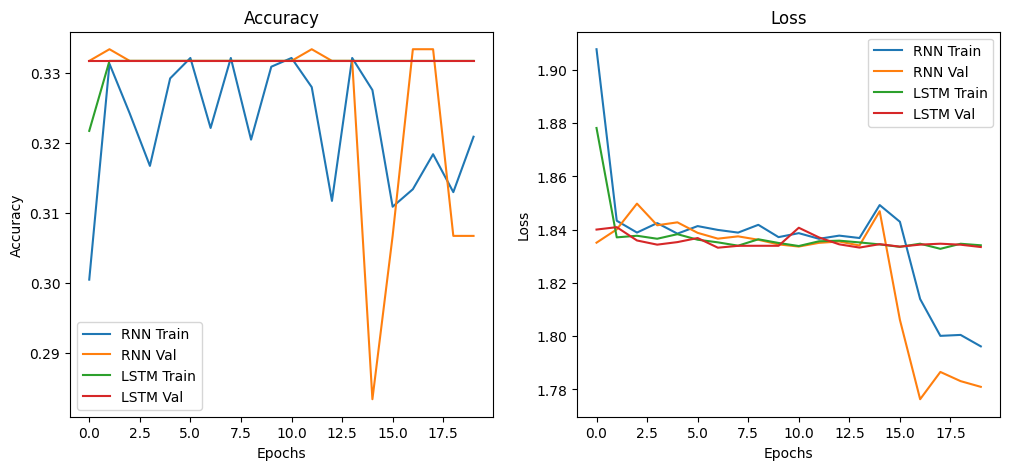

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, one_hot_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

# Define function to build model

def build_model(model_type='RNN', input_dim=10000, embed_dim=64, maxlen=100, num_classes=9):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embed_dim, input_shape=(maxlen,)))

    if model_type == 'RNN':
        model.add(SimpleRNN(64))
    elif model_type == 'LSTM':
        model.add(LSTM(64))
    else:
        raise ValueError("model_type must be 'RNN' or 'LSTM'")

    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


#  Train RNN

rnn_model = build_model('RNN')
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


#  Train LSTM

lstm_model = build_model('LSTM')
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


# 5. Plot comparison

plt.figure(figsize=(12,5))

# Training Accuracy
plt.subplot(1,2,1)
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(1,2,2)
plt.plot(history_rnn.history['loss'], label='RNN Train')
plt.plot(history_rnn.history['val_loss'], label='RNN Val')
plt.plot(history_lstm.history['loss'], label='LSTM Train')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
=== RNN Classification Report ===
                           precision    recall  f1-score   support

Child Sexual Exploitation       0.00      0.00      0.00        21
                Elections       0.00      0.00      0.00        22
       Non-Violent Crimes       0.00      0.00      0.00        60
                     Safe       0.29      0.67      0.40       199
       Sex-Related Crimes       0.00      0.00      0.00        23
      Suicide & Self-Harm       0.00      0.00      0.00        23
           Unknown S-Type       0.00      0.00      0.00        39
           Violent Crimes       0.38      0.32      0.34       158
                   unsafe       0.00      0.00      0.00        55

                 accuracy                           0.31       600
                macro avg       0.07      0.11      0.08       600
             weighted avg       0.19      0.31      0.22       600

=== LSTM Cla

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

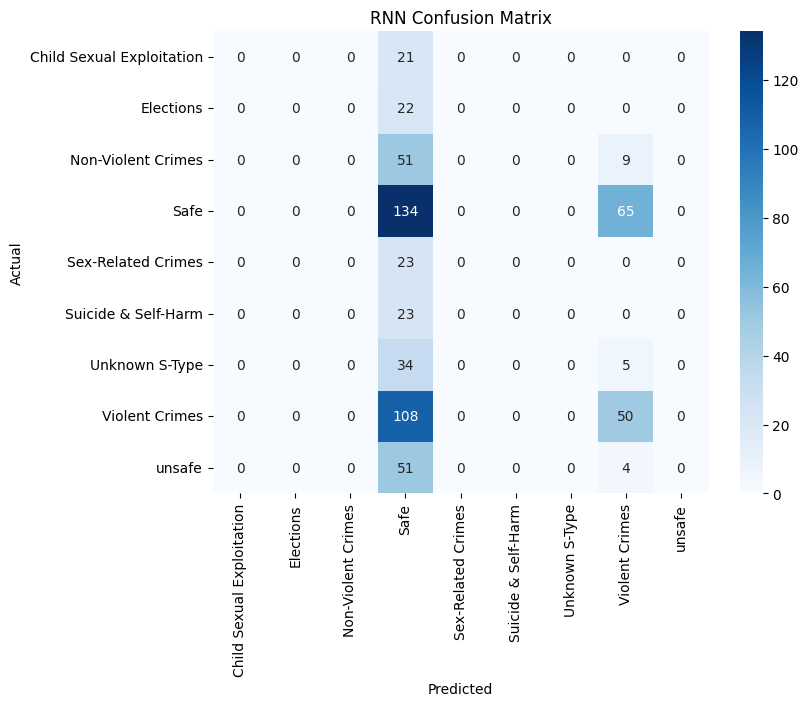

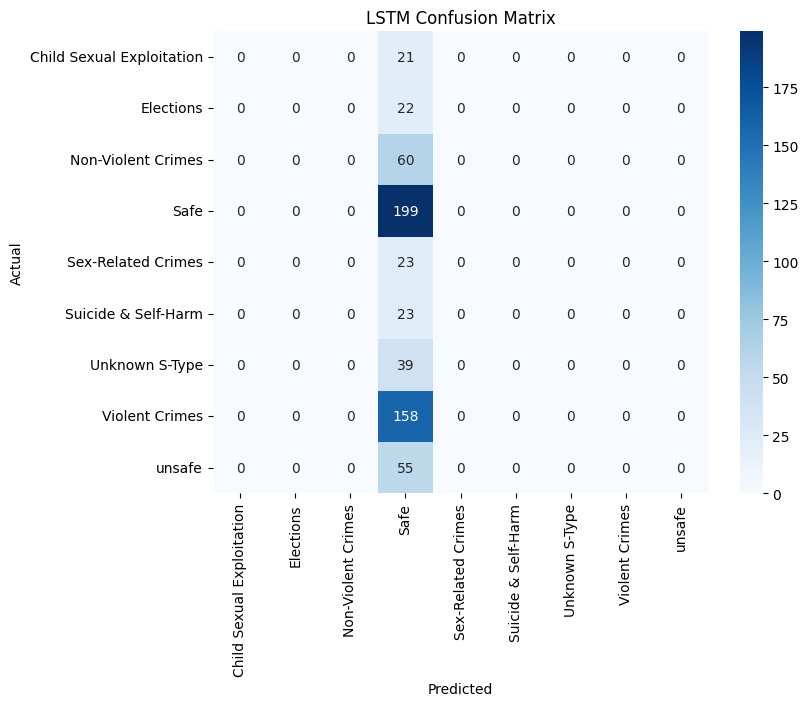

In [25]:


# Predict classes

y_pred_rnn = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)


y_pred_rnn_classes = y_pred_rnn.argmax(axis=1)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)


y_true_classes = y_test.argmax(axis=1)


# Classification report

print("=== RNN Classification Report ===")
print(classification_report(y_true_classes, y_pred_rnn_classes, target_names=label_encoder.classes_))

print("=== LSTM Classification Report ===")
print(classification_report(y_true_classes, y_pred_lstm_classes, target_names=label_encoder.classes_))


# Confusion matrix

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_true_classes, y_pred_rnn_classes, title='RNN Confusion Matrix')
plot_confusion_matrix(y_true_classes, y_pred_lstm_classes, title='LSTM Confusion Matrix')


In [26]:



def get_metrics(y_true, y_pred, model_name):
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average='macro'),
        "Micro F1": f1_score(y_true, y_pred, average='micro')
    }
    return metrics

# RNN metrics
metrics_rnn = get_metrics(y_true_classes, y_pred_rnn_classes, "RNN")

# LSTM metrics
metrics_lstm = get_metrics(y_true_classes, y_pred_lstm_classes, "LSTM")

df_metrics = pd.DataFrame([metrics_rnn, metrics_lstm])
print(df_metrics)


  Model  Accuracy  Macro F1  Micro F1
0   RNN  0.306667  0.082894  0.306667
1  LSTM  0.331667  0.055347  0.331667


In [28]:
from datasets import Dataset

dataset = Dataset.from_dict({
    'text': articles,
    'label': encoded_labels
})


dataset = dataset.train_test_split(test_size=0.2, seed=42)


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16043832.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 